In [48]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Modelling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from math import sqrt
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

## Import the CSV Data

In [25]:
df = pd.read_csv('./data/loaded_scraped_apartment_sales_data.csv')
df.head()

,Unnamed: 0,price_sold_sek,number_of_rooms,area_size,has_elevator,year_built,annual_fee_sek,annual_cost_sek,region_processed_bromma,region_processed_centrala sundbyberg,...,region_processed_årsta,region_processed_östermalm,has_balcony_nej,has_balcony_unknown,cleaned_floor_number,brokerage_firm_processed_erik olsson fastighetsförmedling,brokerage_firm_processed_fastighetsbyrån stockholm - södermalm,brokerage_firm_processed_länsförsäkringar fastighetsförmedling solna,brokerage_firm_processed_notar,brokerage_firm_processed_tradition mäkleri
0,0,4400000,3.0,74.0,False,1953.0,4899.0,9000.0,False,False,...,False,False,False,False,2.000000,False,False,False,False,False
1,1,1015000,1.0,25.0,True,1961.0,2265.0,3120.0,False,False,...,False,False,False,True,4.000000,False,False,False,False,False
2,2,7450000,3.0,725.0,False,2023.0,4428.0,0.0,False,False,...,False,False,False,False,4.476867,False,False,False,False,False
3,3,1395000,1.0,40.0,True,1955.0,3250.0,4500.0,False,False,...,False,False,False,False,2.000000,False,False,False,False,False
4,4,3150000,1.0,31.0,True,1963.0,1290.0,6804.0,False,False,...,False,False,False,False,1.000000,False,False,False,True,False


https://www.youtube.com/watch?v=gqqGdu1P2FM&t=1706s&ab_channel=KrishNaik

## Split Data

In [26]:
X = df.drop(['price_sold_sek', 'Unnamed: 0'], axis=1)
y = df['price_sold_sek']

In [27]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
  [
    ("OneHotEncoder", oh_transformer, cat_features),
    ("StandardScaler", numeric_transformer, num_features)
  ]
)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

## Train and Test Models

In [29]:
def evaluate_model(observed_values, predictions):
  mse = mean_squared_error(observed_values, predictions)
  rmse = mean_squared_error(observed_values, predictions, squared=False)
  mae = mean_absolute_error(observed_values, predictions)
  r2 = r2_score(observed_values, predictions)
  #print(f"MSE: {mse} \nRMSE: {rmse} \nMAE: {mae} \nR-squared: {r2}")
  return mae, rmse, r2


In [30]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting process needed as it's a direct transformation
        return self

    def transform(self, X):
        # Apply log1p transformation
        return np.log1p(X)

    def inverse_transform(self, X):
        # Apply expm1 to inverse the log1p transformation
        return np.expm1(X)

In [31]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost": AdaBoostRegressor()
}

# Wrap each model with TransformedTargetRegressor for log transformation
"""models = {
    "Linear Regression": TransformedTargetRegressor(regressor=LinearRegression(), transformer=LogTransformer()),
    "Lasso": TransformedTargetRegressor(regressor=Lasso(), transformer=LogTransformer()),
    "Ridge": TransformedTargetRegressor(regressor=Ridge(), transformer=LogTransformer()),
    "K-Neighbors Regressor": TransformedTargetRegressor(regressor=KNeighborsRegressor(), transformer=LogTransformer()),
    "Decision Tree": TransformedTargetRegressor(regressor=DecisionTreeRegressor(), transformer=LogTransformer()),
    "Random Forest Regressor": TransformedTargetRegressor(regressor=RandomForestRegressor(), transformer=LogTransformer()),
    "XGBRegressor": TransformedTargetRegressor(regressor=XGBRegressor(), transformer=LogTransformer()),
    "CatBoosting Regressor": TransformedTargetRegressor(regressor=CatBoostRegressor(verbose=False), transformer=LogTransformer()),
    "AdaBoost": TransformedTargetRegressor(regressor=AdaBoostRegressor(), transformer=LogTransformer())
}"""

model_list = []
r2_list = []
mae_list = []

for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate the model on both sets
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Append the model name and test R2 score to their respective lists
    model_list.append(model_name)
    r2_list.append(model_test_r2)
    mae_list.append(model_test_mae)
    
    # Print the performance metrics
    print(f"\nModel: {model_name}")
    print('Model performance for Training set:')
    print(f"- Root Mean Square Error: {model_train_rmse:.4f}")
    print(f"- Mean Absolute Error: {model_train_mae:.4f}")
    print(f"- R2 Score: {model_train_r2:.4f}")
    print("-" * 35)
    print('Model performance for Test set:')
    print(f"- Root Mean Square Error: {model_test_rmse:.4f}")
    print(f"- Mean Absolute Error: {model_test_mae:.4f}")
    print(f"- R2 Score: {model_test_r2:.4f}")
    print("=" * 35 + "\n")

/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Model: Linear Regression
Model performance for Training set:
- Root Mean Square Error: 1757105.8246
- Mean Absolute Error: 1270716.5543
- R2 Score: 0.5686
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 1773014.0252
- Mean Absolute Error: 1300096.4623
- R2 Score: 0.5339



/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packa


Model: Lasso
Model performance for Training set:
- Root Mean Square Error: 1757105.8249
- Mean Absolute Error: 1270716.6291
- R2 Score: 0.5686
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 1773012.5961
- Mean Absolute Error: 1300093.3059
- R2 Score: 0.5339


Model: Ridge
Model performance for Training set:
- Root Mean Square Error: 1757385.6451
- Mean Absolute Error: 1270342.6690
- R2 Score: 0.5685
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 1773971.5977
- Mean Absolute Error: 1298989.0824
- R2 Score: 0.5334



/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packa


Model: K-Neighbors Regressor
Model performance for Training set:
- Root Mean Square Error: 2025673.5983
- Mean Absolute Error: 1415748.2565
- R2 Score: 0.4267
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 2588318.9333
- Mean Absolute Error: 1788763.9151
- R2 Score: 0.0067


Model: Decision Tree
Model performance for Training set:
- Root Mean Square Error: 4297.5885
- Mean Absolute Error: 147.7541
- R2 Score: 1.0000
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 1776150.0387
- Mean Absolute Error: 1181747.6415
- R2 Score: 0.5322



/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packa


Model: Random Forest Regressor
Model performance for Training set:
- Root Mean Square Error: 516678.9018
- Mean Absolute Error: 328644.9847
- R2 Score: 0.9627
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 1300455.6808
- Mean Absolute Error: 862668.6399
- R2 Score: 0.7492


Model: XGBRegressor
Model performance for Training set:
- Root Mean Square Error: 234124.9570
- Mean Absolute Error: 163282.4426
- R2 Score: 0.9923
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 1238461.5683
- Mean Absolute Error: 839186.4306
- R2 Score: 0.7726


Model: CatBoosting Regressor
Model performance for Training set:
- Root Mean Square Error: 555887.0901
- Mean Absolute Error: 411454.1260
- R2 Score: 0.9568
-----------------------------------
Model performance for Test set:
- Root Mean Square Error: 1175152.7267
- Mean Absolute Error: 783723.9513
- R2 Score: 0.7952


Model: AdaBoost
Model performance for Training

/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ossianhempel/repos/apartment_price_predictor/venv/lib/python3.10/site-packa

## Results

In [32]:
# Create a DataFrame with model names, their R2 scores, and MAE scores
results_df = pd.DataFrame(list(zip(model_list, r2_list, mae_list)),
                          columns=['Model Name', 'R2_Score', 'MAE'])

# Sort the DataFrame by R2_Score in descending order (you might also consider sorting by MAE or a combination)
sorted_results_df = results_df.sort_values(by='R2_Score', ascending=False)

# Display the sorted DataFrame
print(sorted_results_df)

                Model Name  R2_Score           MAE
7    CatBoosting Regressor  0.795236  7.837240e+05
6             XGBRegressor  0.772579  8.391864e+05
5  Random Forest Regressor  0.749241  8.626686e+05
1                    Lasso  0.533890  1.300093e+06
0        Linear Regression  0.533889  1.300096e+06
2                    Ridge  0.533386  1.298989e+06
4            Decision Tree  0.532239  1.181748e+06
8                 AdaBoost  0.441634  1.625658e+06
3    K-Neighbors Regressor  0.006655  1.788764e+06


# CatBoost (best performing model)

In [33]:
model = CatBoostRegressor()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

predictions

Learning rate set to 0.04449
0:	learn: 2615969.7032126	total: 871us	remaining: 871ms
1:	learn: 2566462.9514203	total: 1.5ms	remaining: 751ms
2:	learn: 2513865.5478723	total: 2.1ms	remaining: 697ms
3:	learn: 2471719.6726745	total: 2.81ms	remaining: 701ms
4:	learn: 2421322.5833168	total: 3.45ms	remaining: 687ms
5:	learn: 2371600.4250099	total: 4.08ms	remaining: 677ms
6:	learn: 2328723.5829506	total: 4.74ms	remaining: 673ms
7:	learn: 2288516.2063216	total: 5.36ms	remaining: 665ms
8:	learn: 2251036.0545921	total: 6.03ms	remaining: 665ms
9:	learn: 2213661.9935823	total: 6.72ms	remaining: 665ms
10:	learn: 2184935.4818626	total: 7.42ms	remaining: 667ms
11:	learn: 2150139.2853709	total: 8.28ms	remaining: 682ms
12:	learn: 2119310.4252430	total: 9.47ms	remaining: 719ms
13:	learn: 2090827.0894780	total: 10.1ms	remaining: 711ms
14:	learn: 2058283.5450932	total: 10.8ms	remaining: 709ms
15:	learn: 2026649.7689299	total: 11.4ms	remaining: 701ms
16:	learn: 1997898.5221245	total: 12ms	remaining: 693ms


array([ 5848099.7941014 ,  4904507.84551774,  5050355.75187742,
        2533381.52038295,  1596473.42542519,  1745628.77476434,
        7185081.97635069,  4975528.42152975,  3281093.47891659,
        6341948.17322428,  4390074.82169097,  4069391.03550551,
       16323810.63752975,  5688392.75696632,  2434473.64842818,
        2100871.11209771,  6234914.59326773, 13579982.86317448,
        2094778.49553843,  3987932.18712173,  7209421.5558277 ,
        2810365.73484357,  2635160.13912411,  3414923.59977668,
       10628548.90793428,  4796150.28267705,  3228251.75684544,
        6064615.74923478,  4624991.35246763,  3940016.84142138,
        1838276.26405994,  1865051.80187263,  2854727.83667548,
        2640542.90549095,  4299857.12345003,  3176951.38618289,
        3870315.40996397,  2109821.5159888 ,  3168416.44890039,
        2274258.04036464,  5815835.72465226,  2351540.15231153,
        6432137.08224576,  4370177.76483526,  3321216.30252514,
        1416309.93639142,  1510706.95125

https://www.youtube.com/watch?v=gqqGdu1P2FM&t=1706s&ab_channel=KrishNaik

## Plot Predicted & Observed Values

Text(0, 0.5, 'Predicted')

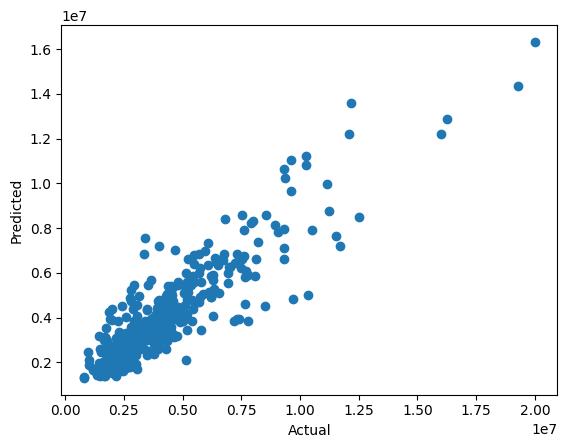

In [34]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='price_sold_sek'>

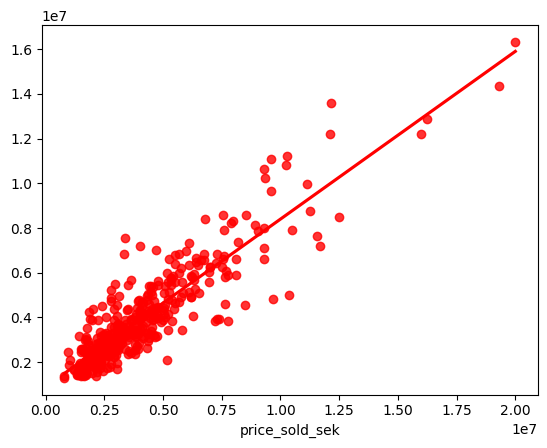

In [35]:
sns.regplot(x=y_test, y=predictions, ci=None, color='red')

## Difference Between Actual & Predicted Values

In [38]:
residuals = y_test - predictions

In [40]:
pred_df = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': predictions, 'Difference': residuals})
pred_df

,Actual Value,Predicted Value,Difference
721,5425000,5.848100e+06,-4.230998e+05
1472,6200000,4.904508e+06,1.295492e+06
170,4350000,5.050356e+06,-7.003558e+05
755,2200000,2.533382e+06,-3.333815e+05
1224,1375000,1.596473e+06,-2.214734e+05
...,...,...,...
139,4650000,4.433397e+06,2.166026e+05
473,9300000,7.980840e+06,1.319160e+06
1405,2250000,3.867315e+06,-1.617315e+06
82,1750000,3.531110e+06,-1.781110e+06


<Axes: ylabel='price_sold_sek'>

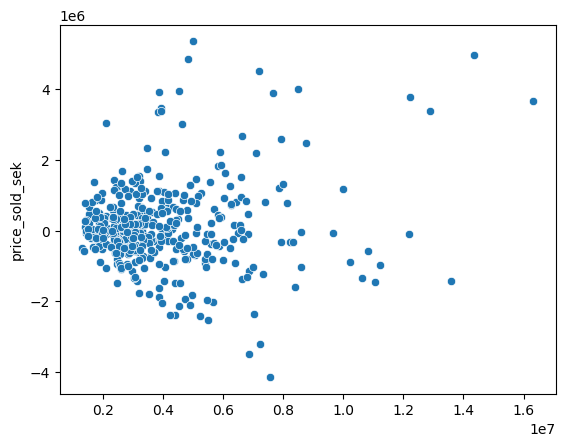

In [43]:
sns.scatterplot(x=predictions, y=residuals)